In [4]:
import tensorflow as tf

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pathlib

AUTOTUNE = tf.data.experimental.AUTOTUNE

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
tf.__version__

'2.0.0'

Based on this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

> `keras.preprocessing` method is convienient, but has two downsides:
- It's slow. See the performance section below.
- It lacks fine-grained control.
- It is not well integrated with the rest of TensorFlow.

So it's better to use `tf.data.Dataset`.

## load using `keras.preprocessing`

### looking into files

In [5]:
data_dir = pathlib.Path.home() / 'data/chest_xray/small'

In [24]:
list(data_dir.glob('*/*'))

[PosixPath('/Users/ilyarudyak/data/chest_xray/small/test/PNEUMONIA'),
 PosixPath('/Users/ilyarudyak/data/chest_xray/small/test/NORMAL'),
 PosixPath('/Users/ilyarudyak/data/chest_xray/small/train/PNEUMONIA'),
 PosixPath('/Users/ilyarudyak/data/chest_xray/small/train/NORMAL'),
 PosixPath('/Users/ilyarudyak/data/chest_xray/small/val/PNEUMONIA'),
 PosixPath('/Users/ilyarudyak/data/chest_xray/small/val/NORMAL')]

In [13]:
train_dir = data_dir / 'train'

In [17]:
num_pneumonia = len(list(train_dir.glob('PNEUMONIA/*')))

In [18]:
num_pneumonia

64

In [19]:
num_normal = len(list(train_dir.glob('NORMAL/*')))

In [20]:
num_normal

64

In [21]:
s = '/Users/ilyarudyak/data/chest_xray/small/test/PNEUMONIA'

In [23]:
s.split('/')[-1]

'PNEUMONIA'

In [28]:
CLASS_NAMES = [str(s).split('/')[-1] for s in train_dir.glob('*')][::-1]

In [29]:
CLASS_NAMES

['NORMAL', 'PNEUMONIA']

In [34]:
image = np.array(Image.open(next(train_dir.glob('NORMAL/*'))))

In [36]:
type(image), image.shape

(numpy.ndarray, (1963, 2172))

In [42]:
# so we need to convert into floats and divide by 255
image[:3, :3]

array([[ 0, 79, 72],
       [ 0, 80, 75],
       [ 0, 81, 76]], dtype=uint8)

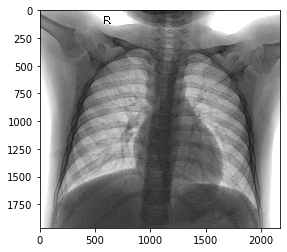

In [41]:
plt.imshow(image, cmap='binary');

### loading files

In [43]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [44]:
BATCH_SIZE = 8
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = 8

In [68]:
train_data_gen = image_generator.flow_from_directory(
    directory=str(train_dir),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes = CLASS_NAMES,
    class_mode = 'sparse'
)

Found 128 images belonging to 2 classes.


In [69]:
image_batch, label_batch = next(train_data_gen)

In [70]:
type(image_batch), type(label_batch), image_batch.shape, label_batch.shape

(numpy.ndarray, numpy.ndarray, (8, 224, 224, 1), (8,))

In [71]:
image_batch[0][0, 0]

array([0.18823531], dtype=float32)

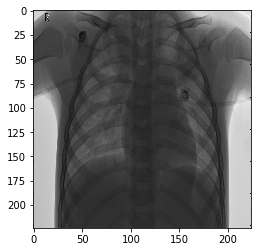

In [72]:
plt.imshow(image_batch[0].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='binary');

In [73]:
label_batch

array([1, 0, 0, 1, 1, 0, 1, 1], dtype=int32)

In [80]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(BATCH_SIZE // 2, BATCH_SIZE // 2, n+1)
        plt.imshow(image_batch[n].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='binary')
        plt.title(CLASS_NAMES[int(label_batch[n])])
        plt.axis('off')

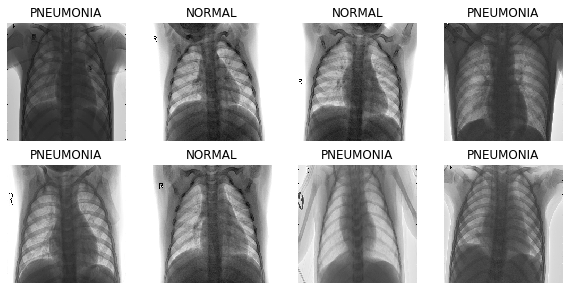

In [81]:
show_batch(image_batch, label_batch)

## load using `tf.data`

And now for the interesting part - let's load data with the new `tf.data` API. We have to provide all low level details for reading and decoding files:

- create list of files (let's start from training files);
- write functions to extract labels and read images;
- use `map` to get 

In [82]:
train_list_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'))

In [84]:
for f in train_list_ds.take(5):
    print(f.numpy())

b'/Users/ilyarudyak/data/chest_xray/small/train/NORMAL/IM-0676-0001.jpeg'
b'/Users/ilyarudyak/data/chest_xray/small/train/NORMAL/IM-0499-0001-0001.jpeg'
b'/Users/ilyarudyak/data/chest_xray/small/train/PNEUMONIA/person507_bacteria_2140.jpeg'
b'/Users/ilyarudyak/data/chest_xray/small/train/PNEUMONIA/person52_bacteria_249.jpeg'
b'/Users/ilyarudyak/data/chest_xray/small/train/NORMAL/IM-0351-0001.jpeg'


In [85]:
CLASS_NAMES

['NORMAL', 'PNEUMONIA']

In [146]:
CLASS_NAMES = np.array(CLASS_NAMES)

In [86]:
CLASS_NAMES_DICT = {'NORMAL': 0, 'PNEUMONIA': 1}

In [109]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, '/')
  # The second to last is the class-directory
  return np.array(CLASS_NAMES) == parts[-2]

In [110]:
file_path = next(iter(train_list_ds))

In [111]:
file_path

<tf.Tensor: id=27152, shape=(), dtype=string, numpy=b'/Users/ilyarudyak/data/chest_xray/small/train/PNEUMONIA/person1014_bacteria_2945.jpeg'>

In [112]:
parts = tf.strings.split(file_path, '/')

In [113]:
parts[-2].numpy().decode('ascii')

'PNEUMONIA'

In [114]:
get_label(file_path)

<tf.Tensor: id=27278, shape=(2,), dtype=bool, numpy=array([False,  True])>

In [115]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=1)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [116]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [117]:
img, label = process_path(file_path)

In [118]:
img.shape

TensorShape([224, 224, 1])

In [119]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = train_list_ds.map(process_path)

In [121]:
for image, label in labeled_ds.take(3):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 1)
Label:  [False  True]
Image shape:  (224, 224, 1)
Label:  [ True False]
Image shape:  (224, 224, 1)
Label:  [ True False]


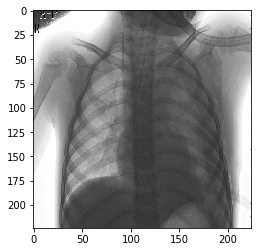

In [122]:
for image, label in labeled_ds.take(1):
    plt.imshow(image.numpy().reshape(224, 224), cmap='binary')

In [148]:
def show_batch2(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(BATCH_SIZE // 2, BATCH_SIZE // 2, n+1)
        plt.imshow(image_batch[n].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='binary')
        plt.title(CLASS_NAMES[label_batch[n]][0])
        plt.axis('off')

In [139]:
label_batch = np.array([False, True])

In [140]:
label_batch == 1

array([False,  True])

In [133]:
np.array(CLASS_NAMES)[label_batch == True][0]

'PNEUMONIA'

In [134]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=32):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [141]:
train_ds = prepare_for_training(labeled_ds)

In [142]:
image_batch, label_batch = next(iter(train_ds))

In [143]:
label_batch.numpy()

array([[False,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [False,  True]])

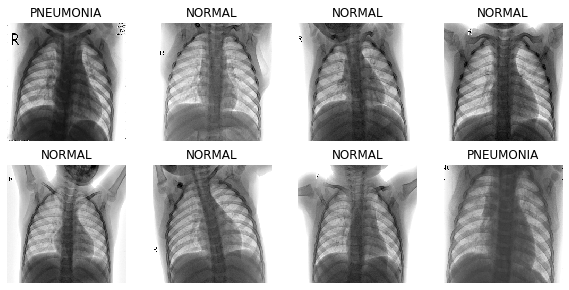

In [149]:
show_batch2(image_batch.numpy(), label_batch.numpy())